In [1]:
import math
import random
import os
import time
import json
from functools import partial
from collections import defaultdict

import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

### Check Version

In [2]:
tf.__version__

'2.9.1'

### GPU Configuration

In [3]:
gpus = tf.config.list_physical_devices('GPU')

2022-11-06 05:38:43.419846: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 05:38:43.423943: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 05:38:43.424236: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.config.experimental.set_memory_growth(gpus[0], True)

### Pandas Config

In [6]:
pd.set_option('display.max_column', None)

### Input Pipeline

In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4

In [8]:
CROP_WIDTH = 227
CROP_HEIGHT = 227

In [9]:
foldFiles = ["adience/unprocessed/fold_0_data.txt",
             "adience/unprocessed/fold_1_data.txt",
             "adience/unprocessed/fold_2_data.txt",
             "adience/unprocessed/fold_3_data.txt",
             "adience/unprocessed/fold_4_data.txt"]

In [10]:
genderMap = defaultdict(lambda : np.NaN)
genderMap['m'] = 0
genderMap['f'] = 1

In [11]:
ages = ['(0, 2)', '(4, 6)', '(8, 13)', '(15, 20)', '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']
ageMap = defaultdict(lambda : np.NaN)
for i,a in enumerate(ages):
    ageMap[a] = i

### Dataset Generation

Dataset generation pipeline:
Input: 
- foldFile - Path to fold file. Fold file Describes which images are in the fold and its corresponding labels
- imgBaseFolder - Base folder to search image from
- imgPrefix - Prefix of image file
- genderMap - Map from ['m', 'f', 'u', None], to one hot index
- ageMap - Map from age category to one hot index
- imgWidth - Resulting image width
- imgHeigh - Resulting image height
- batchSize - Int or None, batch size
- configureDs - Function accepting dataset for performance configurations
- preBatch - List of (name, functions) pair that will be mapped before batching. name is used as name parameters for tf graph 
- postBatch - List of (name, functions) that will be mapped after batching. name is used as name parameters for tf graph

The processing functions should have signature function(img, label) -> (img, label)

Pipeline

Read Fold File -> Preprocess filename and labels (dataframe) -> Convert filename and labels to numpy array -> Convert filename and labels to tf dataset -> Parse images and labels -> Configure Dataset for performance -> Pre-Batching preprocessing -> Batch -> Post-Batching preprocessing -> Output

Some preprocessing steps can only be done before and some can only be done after batching, thats why there are seperated pre and post batching list

In [12]:
def generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, batchSize, configureDs=None, preBatch=[], postBatch=[]):
    
    def parseImage(filename):
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [imgHeight, imgWidth])
         
        return img
    
    # Read Fold File
    foldData = []
    for f in foldFiles:
        foldData.append(pd.read_csv(f, sep="\t"))
    foldData = pd.concat(foldData)
    
    # Form File Name
    foldData['filename'] = foldData.apply(lambda r: os.path.join(imgBaseFolder, r['user_id'], f"{imgPrefix}.{r['face_id']}.{r['original_image']}"), axis=1)
    
    # Generate Label One Hot Index
    foldData['gender_ind'] = foldData['gender'].map(genderMap)
    foldData['age_ind'] = foldData['age'].map(ageMap)
    
    # Remove dirty data
    foldData.dropna(subset=['gender_ind', 'age_ind'], inplace=True)
    
    # Dataframe to numpy
    filenames = foldData['filename'].to_numpy()
    
    genderIndex = foldData['gender_ind'].to_numpy().astype(int)
    ageIndex = foldData['age_ind'].to_numpy().astype(int)
    
    # Numpy to Dataset
    fnDs = tf.data.Dataset.from_tensor_slices(filenames)
    genderIndDs = tf.data.Dataset.from_tensor_slices(genderIndex)
    ageIndDs = tf.data.Dataset.from_tensor_slices(ageIndex)
    
    # Parse Images
    imageDs = fnDs.map(parseImage, num_parallel_calls=tf.data.AUTOTUNE, name="parse_image")
    
    # Parse Labels
    genderLabDs = genderIndDs.map(lambda x: tf.one_hot(x, genderDepth), num_parallel_calls=tf.data.AUTOTUNE, name="gender_one_hot")
    ageLabDs = ageIndDs.map(lambda x: tf.one_hot(x, ageDepth), num_parallel_calls=tf.data.AUTOTUNE, name="age_one_hot")
    
    # Combine Labels
    labelDs = tf.data.Dataset.zip((genderLabDs, ageLabDs), name="label_zip")
    labelDs = labelDs.map(lambda g,a: {"gender": g, "age": a}, num_parallel_calls=tf.data.AUTOTUNE, name='label_dict')
    
    # Combine Images and Labels into dataset
    ds = tf.data.Dataset.zip((imageDs, labelDs))
    
    # Configure Performance
    if(configureDs is not None):
        ds = configureDs(ds)
    
    # Pre Batch Preprocessing
    for n,f in preBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    # Batch
    if(batchSize is not None):
        ds = ds.batch(batchSize, name="ds_batch")
    
    # Post Batch Preprocessing
    for n,f in postBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    return ds

### Preprocessings

In [13]:
def trainConfigPerformance(ds):
    #ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.repeat()
    return ds

In [14]:
def valConfigPerformance(ds):
    #ds = ds.cache()
    return ds

#### Preprocessing steps

In [15]:
def trainPreprocessA(img, lab):
        
        ud = tf.random.uniform([], dtype=tf.float32)
        udCond = tf.less(ud, 0.5)
        
        img = tf.cond(udCond, lambda: tf.image.flip_up_down(img), lambda: img)
        
        lr = tf.random.uniform([], dtype=tf.float32)
        lrCond = tf.less(lr, 0.5)
        
        img = tf.cond(lrCond, lambda: tf.image.flip_left_right(img), lambda: img)
        
        img = tf.image.random_brightness(img, 63/255)
        
        img = tf.image.random_contrast(img, 0.2, 1.8)
        
        return img, lab

In [16]:
def preprocessB(img, lab, rotL, rotH, shXL, shXH, shYL, shYH, zoomL, zoomH, hTransL, hTransH, vTransL, vTransH):
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    rRot = tf.random.uniform([shape[0]], minval=rotL, maxval=rotH, dtype=tf.float32)
    rShearX = tf.random.uniform([shape[0]], minval=shXL, maxval=shXH, dtype=tf.float32)
    rShearY = tf.random.uniform([shape[0]], minval=shYL, maxval=shYH, dtype=tf.float32)
    rZoom = tf.random.uniform([shape[0]], minval=zoomL, maxval=zoomH, dtype=tf.float32) #% Zoom
    rTx = tf.random.uniform([shape[0]], minval=hTransL, maxval=hTransH, dtype=tf.float32) #% Horiz Translation
    rTy = tf.random.uniform([shape[0]], minval=vTransL, maxval=vTransH, dtype=tf.float32) #% Vert Translation

    cT = tf.math.cos(rRot)
    sT = tf.math.sin(rRot)

    one = tf.ones([shape[0]], dtype=tf.float32)
    zero = tf.zeros([shape[0]], dtype=tf.float32)

    transC = tf.stack([[1, 0, -shapeF[2]/2], [0, 1, -shapeF[1]/2], [0, 0, 1]])
    transCI = tf.stack([[1, 0, shapeF[2]/2], [0, 1, shapeF[1]/2], [0, 0, 1]])

    trans = tf.transpose(tf.stack([[one, zero, rTx*shapeF[2]], [zero, one, rTy*shapeF[1]], [zero, zero, one]]), [2,0,1])
    rot = tf.transpose(tf.stack([[cT, -sT, zero], [sT, cT, zero], [zero, zero, one]]), [2,0,1])
    scale = tf.transpose(tf.stack([[rZoom, rShearX, zero], [rShearY, rZoom, zero], [zero, zero, one]]), [2,0,1])

    rotScale = rot@scale

    afTMat = transCI @ trans @ rotScale @ transC
    afT = tf.reshape(afTMat, [shape[0], -1])[:,:-1]

    img = tf.raw_ops.ImageProjectiveTransformV3(interpolation='NEAREST', images=img, transforms=afT, output_shape=shape[1:3], fill_value=0)

    return img, lab

In [17]:
def preprocessNoise(img, lab, gMean, gStd, spAmountP, spRatio, speckleVar):
        
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    # Gaussian Noise
    gNoise = tf.random.normal(shape, gMean, gStd)

    img += gNoise

    # Salt and pepper noise
    spMask = tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spAmountP), tf.float32)
    spNoise = 255*tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spRatio), tf.float32)

    img = tf.math.add(tf.math.multiply(img, 1.0 - spMask), tf.math.multiply(spNoise, spMask))

    # Speckles
    sNoise = speckleVar * tf.random.normal(shape)
    img = img + tf.math.multiply(img, sNoise)

    img = tf.clip_by_value(img, 0, 255)

    return img, lab

In [18]:
def clipValue(img, lab):
    img = tf.clip_by_value(img, 0.0, 255.0)
    return img, lab

In [19]:
def valPreprocessA(img, lab):
        
        img = tf.image.crop_to_bounding_box(img,
                                            (IMG_HEIGHT-CROP_HEIGHT) // 2,
                                            (IMG_WIDTH-CROP_WIDTH) // 2,
                                            CROP_HEIGHT,
                                            CROP_WIDTH)
        
        return img, lab

#### Label extractor 

In [20]:
def prepareLabel(img, lab):
    
    lab = lab['gender']
    
    return img, {"recon" : img, "gender" : lab }

### Generate Folds for K-Folds validation

In [21]:
def generateFoldDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, valBatchSize, trainConfigureDs=None, trainPreBatch=[], trainPostBatch=[], valConfigureDs=None, valPreBatch=[], valPostBatch=[]):
    '''
        Returns list of (train, validation) datasets
    '''
    
    N = len(foldFiles)
    
    folds = []
    
    for i in range(N):
        
        trainFiles = foldFiles[:i]
        if(i < N-1):
            trainFiles.extend(foldFiles[i+1:])
            
        valFiles = foldFiles[i]
        
        trainDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, configureDs=trainConfigureDs, preBatch=trainPreBatch, postBatch=trainPostBatch)
        valDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, valBatchSize, configureDs=valConfigureDs, preBatch=valPreBatch, postBatch=valPostBatch)
        
        folds.append((trainDs, valDs))
        
    return folds

In [22]:
genParams = {
            "rotation": [-math.pi, math.pi],
            "shearX": [-0.2, 0.2],
            "shearY": [-0.2, 0.2],
            
            "zoom": [0.8, 1.2], # +- 20%
            "hTranslation": [-0.2, 0.2], # +- 20%
            "vTranslation": [-0.2, 0.2], # +- 20%
            
            "gaussianMean": 0.0,
            "gaussianStd": 2.0,
            
            "spAmount": 0.0001,
            "spRatio": 0.5,
            
            "speckleVar": 0.01
        }

In [23]:
trainPreprocessB = partial(preprocessB,
                           rotL = genParams['rotation'][0],
                           rotH = genParams['rotation'][1],
                           shXL = genParams['shearX'][0],
                           shXH = genParams['shearX'][1], 
                           shYL = genParams['shearY'][0],
                           shYH = genParams['shearY'][1],
                           zoomL = genParams['zoom'][0],
                           zoomH = genParams['zoom'][1],
                           hTransL = genParams['hTranslation'][0],
                           hTransH = genParams['hTranslation'][1],
                           vTransL = genParams['vTranslation'][0],
                           vTransH = genParams['vTranslation'][1])

In [24]:
trainPreprocessC = partial(preprocessNoise,
                           gMean = genParams['gaussianMean'],
                           gStd = genParams['gaussianStd'],
                           spAmountP = genParams['spAmount'],
                           spRatio = genParams['spRatio'],
                           speckleVar = genParams['speckleVar'])

In [25]:
trainPreBatch = [("train_process_a", trainPreprocessA)]
trainPostBatch = [("train_process_b", trainPreprocessB),
                  ("train_process_c", trainPreprocessC),
                  ("train_clip", clipValue),
                  ("train_prepare_label", prepareLabel)]

valPreBatch = [("val_prepare_label", prepareLabel)]

In [26]:
folds = generateFoldDs(foldFiles, "adience/faces", "coarse_tilt_aligned_face", genderMap, ageMap, 2, 8, 
                       IMG_WIDTH, IMG_HEIGHT, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE, 
                       trainConfigureDs=trainConfigPerformance, trainPreBatch=trainPreBatch, 
                       trainPostBatch=trainPostBatch,
                       valConfigureDs=valConfigPerformance, valPreBatch=valPreBatch)

2022-11-06 05:38:43.682609: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-06 05:38:43.683362: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 05:38:43.683663: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 05:38:43.683910: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [27]:
len(folds)

5

### Check data

In [28]:
for x,y in folds[0][0].take(1):
    pass

In [29]:
x

<tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
array([[[[2.04881592e+02, 2.23534088e+02, 2.02305496e+02],
         [2.01787109e+02, 2.23684769e+02, 2.02337952e+02],
         [1.99106003e+02, 2.24217728e+02, 1.95696167e+02],
         ...,
         [0.00000000e+00, 7.67424166e-01, 1.54093489e-01],
         [8.45145524e-01, 7.72297740e-01, 0.00000000e+00],
         [0.00000000e+00, 4.92564499e-01, 0.00000000e+00]],

        [[1.86775436e+02, 2.07950424e+02, 1.91944672e+02],
         [1.96147202e+02, 2.18234741e+02, 2.02772964e+02],
         [2.03211487e+02, 2.24435379e+02, 2.07118362e+02],
         ...,
         [7.54938245e-01, 1.17513835e+00, 0.00000000e+00],
         [0.00000000e+00, 1.40875840e+00, 2.28972101e+00],
         [1.18542981e+00, 0.00000000e+00, 2.47145504e-01]],

        [[1.92487198e+02, 2.11759949e+02, 1.92545349e+02],
         [1.90650818e+02, 2.15899063e+02, 1.91139969e+02],
         [1.88029495e+02, 2.14884094e+02, 1.90986847e+02],
         ...,
         [5

In [30]:
y

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[2.04881592e+02, 2.23534088e+02, 2.02305496e+02],
          [2.01787109e+02, 2.23684769e+02, 2.02337952e+02],
          [1.99106003e+02, 2.24217728e+02, 1.95696167e+02],
          ...,
          [0.00000000e+00, 7.67424166e-01, 1.54093489e-01],
          [8.45145524e-01, 7.72297740e-01, 0.00000000e+00],
          [0.00000000e+00, 4.92564499e-01, 0.00000000e+00]],
 
         [[1.86775436e+02, 2.07950424e+02, 1.91944672e+02],
          [1.96147202e+02, 2.18234741e+02, 2.02772964e+02],
          [2.03211487e+02, 2.24435379e+02, 2.07118362e+02],
          ...,
          [7.54938245e-01, 1.17513835e+00, 0.00000000e+00],
          [0.00000000e+00, 1.40875840e+00, 2.28972101e+00],
          [1.18542981e+00, 0.00000000e+00, 2.47145504e-01]],
 
         [[1.92487198e+02, 2.11759949e+02, 1.92545349e+02],
          [1.90650818e+02, 2.15899063e+02, 1.91139969e+02],
          [1.88029495e+02, 2.14884094e+02, 1.90986847e+0

<IPython.core.display.Javascript object>


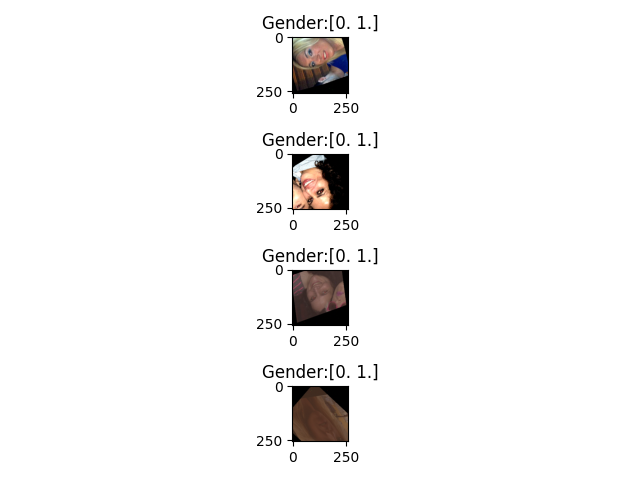

In [31]:
fig1, ax1 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=1)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax1.imshow(x/255)
    ax1.set_title(y)
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax1[i].imshow(x[i]/255)
        ax1[i].set_title(f"Gender:{y['gender'][i]}")
        
plt.tight_layout()

### Model

In [32]:
def createModel(latentSize):
    inp = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    encoder = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, 7, strides=(4,4), padding='same', activation='relu', name='enc_conv1'),
        tf.keras.layers.Conv2D(128, 5, strides=(2,2), padding='same', activation='relu', name='enc_conv2'),
        tf.keras.layers.Conv2D(256, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv3'),
        tf.keras.layers.Conv2D(32, 1, padding='same', activation='relu', name='enc_conv4'),
        tf.keras.layers.Flatten(name="enc_flat"),
        tf.keras.layers.Dense(latentSize, name="enc_out")
    ], name='enc')
    
    decoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(latentSize), name='dec_inp'),
        tf.keras.layers.Dense(8*8*64, activation='relu', name='dec_fc1'),
        tf.keras.layers.Reshape(target_shape=(8,8,64), name='dec_reshape'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv1'),
        tf.keras.layers.Conv2DTranspose(256, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv2'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv3'),
        tf.keras.layers.Conv2DTranspose(64, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv4'),
        tf.keras.layers.Conv2DTranspose(3, 3, strides=(2,2), padding='same', activation='tanh', name='dec_deconv5')
    ], name='dec')

    fc1 = tf.keras.layers.Dense(258, activation='relu', name='fc1')
    do1 = tf.keras.layers.Dropout(0.5, name='do1')

    fc2 = tf.keras.layers.Dense(2, activation='softmax', name='gender_out')
    
    # Preprocess Input
    preInp = inp / 127.5 - 1.0
    
    latent = encoder(preInp)
    recon = decoder(latent)
    recon = tf.math.multiply((recon + 1.0), 127.5, name='recon')
    
    o = fc1(latent)
    o = do1(o)
    
    outLab = fc2(o)
    
    model = tf.keras.models.Model(inputs=inp, outputs={"recon": recon, "gender": outLab}, name='AE_20')
    
    #encoder.summary()
    #decoder.summary()
    
    return model

In [33]:
LATENT_SIZE = 128

In [34]:
model = createModel(LATENT_SIZE)

In [35]:
model.summary()

Model: "AE_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 256, 256, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 enc (Sequential)               (None, 128)          1566496     ['tf.math.subtract[0][0]']   

### Compile Model

In [36]:
STEPS_PER_EPOCH = 1000
EPOCH = 300

START_EPOCH = 0
END_EPOCH = START_EPOCH + EPOCH

#### Learning Rate Schedule

In [37]:
def schedule(epoch, lr):
    return lr

In [38]:
logBasePath = "log/AE_20"
logPrefix = "log"

In [39]:
for i, (train, val) in enumerate([folds[0]]):
    
    model = createModel(LATENT_SIZE)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0002)
    loss = {"gender": tf.keras.losses.CategoricalCrossentropy(), "recon": tf.keras.losses.MeanSquaredError()}
    lossWeight = {"gender": 2500, "recon": 1}
    metrics = {"gender": 'accuracy'}
    
    model.compile(optimizer=opt, loss=loss, loss_weights=lossWeight, metrics=metrics)
    
    tboardCb = tf.keras.callbacks.TensorBoard(log_dir=f"{logBasePath}/{logPrefix}_{i}", histogram_freq=1, profile_batch=(2,10))
    lrSchedule = tf.keras.callbacks.LearningRateScheduler(schedule)
    
    cbs = [tboardCb]
    
    model.evaluate(val)
    model.fit(train, initial_epoch=START_EPOCH, epochs=END_EPOCH, steps_per_epoch=STEPS_PER_EPOCH, callbacks=cbs, validation_data=val)

2022-11-06 05:38:47.183742: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-06 05:38:47.183765: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-11-06 05:38:47.183785: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1665] Profiler found 1 GPUs
2022-11-06 05:38:47.269214: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-06 05:38:47.270551: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-06 05:38:47.907097: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


  14/3528 [..............................] - ETA: 14s - loss: 7269.8008 - gender_out_loss: 0.6954 - tf.math.multiply_1_loss: 5531.4229 - gender_out_accuracy: 0.4821    

2022-11-06 05:38:48.636240: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3528/3528 [==============================] - 15s 4ms/step - loss: 7726.2388 - gender_out_loss: 0.6942 - tf.math.multiply_1_loss: 5990.8149 - gender_out_accuracy: 0.4718
Epoch 1/300
   1/1000 [..............................] - ETA: 13:41 - loss: 8855.6025 - gender_out_loss: 0.6956 - tf.math.multiply_1_loss: 7116.5479 - gender_out_accuracy: 0.5000

2022-11-06 05:39:02.889648: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-06 05:39:02.889750: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


  18/1000 [..............................] - ETA: 43s - loss: 8894.3037 - gender_out_loss: 0.6566 - tf.math.multiply_1_loss: 7252.9111 - gender_out_accuracy: 0.5694 

2022-11-06 05:39:03.437205: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-06 05:39:03.437875: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-06 05:39:03.467173: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 2873 callback api events and 2832 activity events. 
2022-11-06 05:39:03.489215: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-06 05:39:03.511766: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/AE_20/log_0/plugins/profile/2022_11_06_05_39_03

2022-11-06 05:39:03.543485: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/AE_20/log_0/plugins/profile/2022_11_06_05_39_03/rachanon-pc1.trace.json.gz
2022-11-06 05:39:03.575184: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log

1000/1000 [==============================] - 22s 21ms/step - loss: 4110.8071 - gender_out_loss: 0.6663 - tf.math.multiply_1_loss: 2445.0093 - gender_out_accuracy: 0.5918 - val_loss: 3510.1033 - val_gender_out_loss: 0.6784 - val_tf.math.multiply_1_loss: 1814.0150 - val_gender_out_accuracy: 0.5747
Epoch 2/300
1000/1000 [==============================] - 20s 20ms/step - loss: 3046.6833 - gender_out_loss: 0.6471 - tf.math.multiply_1_loss: 1428.8539 - gender_out_accuracy: 0.6298 - val_loss: 3209.5674 - val_gender_out_loss: 0.6843 - val_tf.math.multiply_1_loss: 1498.8514 - val_gender_out_accuracy: 0.5602
Epoch 3/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2824.7256 - gender_out_loss: 0.6480 - tf.math.multiply_1_loss: 1204.7064 - gender_out_accuracy: 0.6058 - val_loss: 3020.1218 - val_gender_out_loss: 0.6877 - val_tf.math.multiply_1_loss: 1300.7700 - val_gender_out_accuracy: 0.5409
Epoch 4/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2760.8

Epoch 28/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2296.1931 - gender_out_loss: 0.6484 - tf.math.multiply_1_loss: 675.1115 - gender_out_accuracy: 0.6198 - val_loss: 2553.8621 - val_gender_out_loss: 0.6985 - val_tf.math.multiply_1_loss: 807.6422 - val_gender_out_accuracy: 0.5771
Epoch 29/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2261.0730 - gender_out_loss: 0.6400 - tf.math.multiply_1_loss: 660.9515 - gender_out_accuracy: 0.6385 - val_loss: 2462.1997 - val_gender_out_loss: 0.6701 - val_tf.math.multiply_1_loss: 787.0381 - val_gender_out_accuracy: 0.5904
Epoch 30/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2236.4585 - gender_out_loss: 0.6284 - tf.math.multiply_1_loss: 665.5151 - gender_out_accuracy: 0.6488 - val_loss: 2688.8035 - val_gender_out_loss: 0.7535 - val_tf.math.multiply_1_loss: 804.9343 - val_gender_out_accuracy: 0.5350
Epoch 31/300
1000/1000 [==============================] - 20s 20ms/step - lo

Epoch 55/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2175.8347 - gender_out_loss: 0.6217 - tf.math.multiply_1_loss: 621.4931 - gender_out_accuracy: 0.6643 - val_loss: 2291.5647 - val_gender_out_loss: 0.6318 - val_tf.math.multiply_1_loss: 712.0534 - val_gender_out_accuracy: 0.6476
Epoch 56/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2146.1438 - gender_out_loss: 0.6161 - tf.math.multiply_1_loss: 605.9191 - gender_out_accuracy: 0.6492 - val_loss: 2337.3555 - val_gender_out_loss: 0.6457 - val_tf.math.multiply_1_loss: 723.0377 - val_gender_out_accuracy: 0.6024
Epoch 57/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2178.3064 - gender_out_loss: 0.6228 - tf.math.multiply_1_loss: 621.4172 - gender_out_accuracy: 0.6538 - val_loss: 2472.8918 - val_gender_out_loss: 0.6887 - val_tf.math.multiply_1_loss: 751.2654 - val_gender_out_accuracy: 0.5669
Epoch 58/300
1000/1000 [==============================] - 20s 20ms/step - lo

Epoch 82/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2144.0884 - gender_out_loss: 0.6257 - tf.math.multiply_1_loss: 579.8355 - gender_out_accuracy: 0.6678 - val_loss: 2253.4600 - val_gender_out_loss: 0.6129 - val_tf.math.multiply_1_loss: 721.1183 - val_gender_out_accuracy: 0.6713
Epoch 83/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2029.1580 - gender_out_loss: 0.5689 - tf.math.multiply_1_loss: 606.7892 - gender_out_accuracy: 0.7088 - val_loss: 2527.2607 - val_gender_out_loss: 0.7218 - val_tf.math.multiply_1_loss: 722.8497 - val_gender_out_accuracy: 0.5526
Epoch 84/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2065.6140 - gender_out_loss: 0.5896 - tf.math.multiply_1_loss: 591.5833 - gender_out_accuracy: 0.6765 - val_loss: 2279.2234 - val_gender_out_loss: 0.6255 - val_tf.math.multiply_1_loss: 715.4742 - val_gender_out_accuracy: 0.6515
Epoch 85/300
1000/1000 [==============================] - 20s 20ms/step - lo

1000/1000 [==============================] - 20s 20ms/step - loss: 2076.0161 - gender_out_loss: 0.5941 - tf.math.multiply_1_loss: 590.6519 - gender_out_accuracy: 0.6710 - val_loss: 2199.2903 - val_gender_out_loss: 0.5989 - val_tf.math.multiply_1_loss: 702.1095 - val_gender_out_accuracy: 0.6759
Epoch 135/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2053.5239 - gender_out_loss: 0.5924 - tf.math.multiply_1_loss: 572.4893 - gender_out_accuracy: 0.6942 - val_loss: 2160.9700 - val_gender_out_loss: 0.5831 - val_tf.math.multiply_1_loss: 703.3107 - val_gender_out_accuracy: 0.7006
Epoch 136/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1942.9778 - gender_out_loss: 0.5444 - tf.math.multiply_1_loss: 582.0944 - gender_out_accuracy: 0.7182 - val_loss: 2237.8784 - val_gender_out_loss: 0.6135 - val_tf.math.multiply_1_loss: 704.1587 - val_gender_out_accuracy: 0.6680
Epoch 137/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2005.7

1000/1000 [==============================] - 20s 20ms/step - loss: 1908.3386 - gender_out_loss: 0.5401 - tf.math.multiply_1_loss: 558.0608 - gender_out_accuracy: 0.7300 - val_loss: 2332.9634 - val_gender_out_loss: 0.6510 - val_tf.math.multiply_1_loss: 705.4230 - val_gender_out_accuracy: 0.6802
Epoch 187/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2109.7922 - gender_out_loss: 0.6086 - tf.math.multiply_1_loss: 588.2244 - gender_out_accuracy: 0.6683 - val_loss: 2128.3074 - val_gender_out_loss: 0.5706 - val_tf.math.multiply_1_loss: 701.7048 - val_gender_out_accuracy: 0.7058
Epoch 188/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1938.8727 - gender_out_loss: 0.5515 - tf.math.multiply_1_loss: 560.0385 - gender_out_accuracy: 0.7232 - val_loss: 2132.7578 - val_gender_out_loss: 0.5670 - val_tf.math.multiply_1_loss: 715.3062 - val_gender_out_accuracy: 0.7125
Epoch 189/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1926.6

1000/1000 [==============================] - 20s 20ms/step - loss: 1814.2413 - gender_out_loss: 0.5016 - tf.math.multiply_1_loss: 560.2590 - gender_out_accuracy: 0.7552 - val_loss: 2093.2119 - val_gender_out_loss: 0.5590 - val_tf.math.multiply_1_loss: 695.7549 - val_gender_out_accuracy: 0.7126
Epoch 239/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1889.2408 - gender_out_loss: 0.5357 - tf.math.multiply_1_loss: 550.1143 - gender_out_accuracy: 0.7305 - val_loss: 2058.5969 - val_gender_out_loss: 0.5495 - val_tf.math.multiply_1_loss: 684.9103 - val_gender_out_accuracy: 0.7111
Epoch 240/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1970.9268 - gender_out_loss: 0.5624 - tf.math.multiply_1_loss: 565.0391 - gender_out_accuracy: 0.7182 - val_loss: 2189.0608 - val_gender_out_loss: 0.5872 - val_tf.math.multiply_1_loss: 720.9595 - val_gender_out_accuracy: 0.6997
Epoch 241/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1844.0

1000/1000 [==============================] - 20s 20ms/step - loss: 1820.6725 - gender_out_loss: 0.5008 - tf.math.multiply_1_loss: 568.6935 - gender_out_accuracy: 0.7638 - val_loss: 1969.9680 - val_gender_out_loss: 0.5058 - val_tf.math.multiply_1_loss: 705.4191 - val_gender_out_accuracy: 0.7488
Epoch 291/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1758.2786 - gender_out_loss: 0.4778 - tf.math.multiply_1_loss: 563.6855 - gender_out_accuracy: 0.7705 - val_loss: 2151.8042 - val_gender_out_loss: 0.5808 - val_tf.math.multiply_1_loss: 699.8464 - val_gender_out_accuracy: 0.7325
Epoch 292/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1831.5657 - gender_out_loss: 0.5093 - tf.math.multiply_1_loss: 558.2639 - gender_out_accuracy: 0.7458 - val_loss: 1994.7770 - val_gender_out_loss: 0.5242 - val_tf.math.multiply_1_loss: 684.2089 - val_gender_out_accuracy: 0.7413
Epoch 293/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1829.3

In [40]:
out = model(x)

In [41]:
out

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[1.67318863e+02, 1.60134491e+02, 1.44520782e+02],
          [1.79835693e+02, 1.74875412e+02, 1.56148392e+02],
          [1.82322540e+02, 1.77324051e+02, 1.57739975e+02],
          ...,
          [2.40527093e-02, 2.55422294e-02, 2.72141397e-02],
          [3.05579603e-02, 3.25186551e-02, 3.80891562e-02],
          [3.31114233e-02, 3.45857441e-02, 4.42904234e-02]],
 
         [[1.81790314e+02, 1.78293213e+02, 1.58471222e+02],
          [1.85668732e+02, 1.84553635e+02, 1.58366440e+02],
          [1.88450378e+02, 1.84433960e+02, 1.61245804e+02],
          ...,
          [2.81792879e-02, 3.75039876e-02, 4.46856022e-02],
          [3.42057645e-02, 3.85907292e-02, 4.22537327e-02],
          [3.92974913e-02, 3.29442322e-02, 3.66300344e-02]],
 
         [[1.88678986e+02, 1.82496826e+02, 1.62228989e+02],
          [1.88576813e+02, 1.83035324e+02, 1.59999680e+02],
          [1.94094238e+02, 1.88581757e+02, 1.65496445e+0

<IPython.core.display.Javascript object>


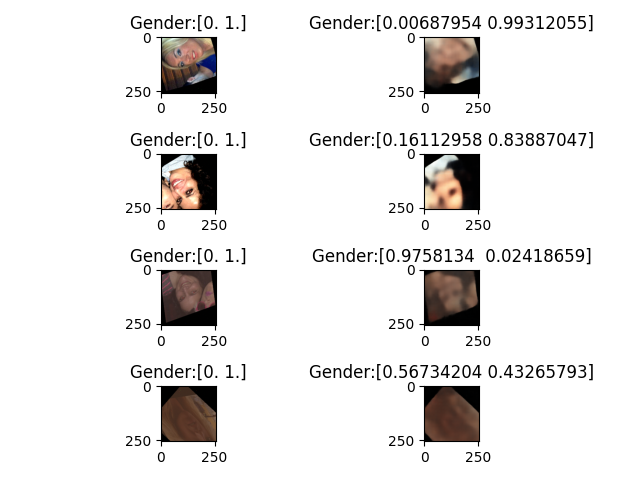

In [42]:
fig2, ax2 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=2)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax2[0].imshow(x/255)
    ax2[0].set_title(y['gender'])
    
    ax2[1].imshow(out['recon']/255)
    ax2[1].set_title(out['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax2[i, 0].imshow(x[i]/255)
        ax2[i, 0].set_title(f"Gender:{y['gender'][i]}")
        
        ax2[i, 1].imshow(out['recon'][i]/255)
        ax2[i, 1].set_title(f"Gender:{out['gender'][i]}")
        
plt.tight_layout()

In [43]:
for xTest, yTest in folds[0][1].take(1):
    pass

In [44]:
outTest = model(xTest)

In [45]:
outTest

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[7.06321299e-01, 6.70869231e-01, 9.52829242e-01],
          [2.61053592e-01, 2.73015350e-01, 4.57480252e-01],
          [5.34661710e-01, 5.08861065e-01, 7.46348381e-01],
          ...,
          [3.83597016e-01, 3.39268595e-01, 3.09166610e-01],
          [5.46463847e-01, 5.27259707e-01, 4.87468243e-01],
          [9.02884722e-01, 8.84653330e-01, 8.51192355e-01]],
 
         [[2.54654735e-01, 2.27995366e-01, 2.74109691e-01],
          [6.47204041e-01, 4.92278785e-01, 5.26324987e-01],
          [1.44935620e+00, 1.05427623e+00, 9.80149806e-01],
          ...,
          [5.72842062e-01, 5.24311066e-01, 4.50952202e-01],
          [6.16562486e-01, 5.97768724e-01, 4.88957763e-01],
          [1.03617406e+00, 9.69958782e-01, 8.10412884e-01]],
 
         [[3.78277302e-01, 3.50918770e-01, 4.89983708e-01],
          [7.33877420e-01, 6.52158976e-01, 9.75491285e-01],
          [1.20850992e+00, 9.13394988e-01, 1.37707651e+0

<IPython.core.display.Javascript object>


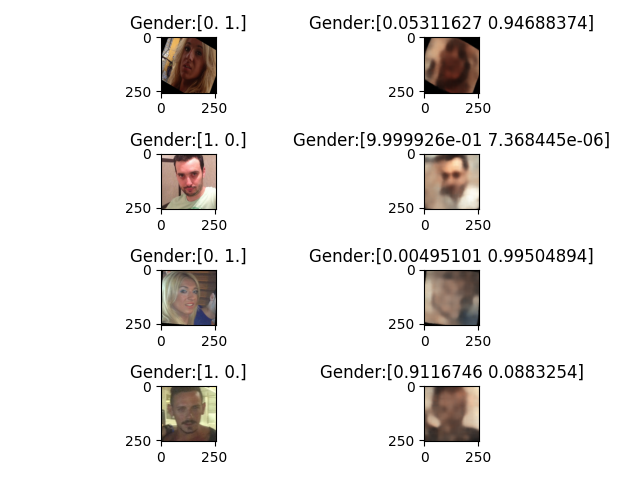

In [46]:
fig3, ax3 = plt.subplots(nrows=VAL_BATCH_SIZE, ncols=2)

if(VAL_BATCH_SIZE is None or VAL_BATCH_SIZE == 1):
    ax3[0].imshow(x/255)
    ax3[0].set_title(yTest['gender'])
    
    ax3[1].imshow(out['recon']/255)
    ax3[1].set_title(outTest['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax3[i, 0].imshow(xTest[i]/255)
        ax3[i, 0].set_title(f"Gender:{yTest['gender'][i]}")
        
        ax3[i, 1].imshow(outTest['recon'][i]/255)
        ax3[i, 1].set_title(f"Gender:{outTest['gender'][i]}")
        
plt.tight_layout()